In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from figure_formatting import figure_formatting as ff
ff.formatting['axes.linewidth'] = 0.5
ff.formatting['lines.linewidth'] = 1.0
ff.set_formatting()
ff.set_formatting()

from scipy.stats import linregress
from scipy.optimize import curve_fit

from dataclasses import dataclass
from sklearn.metrics import r2_score

@dataclass
class RegressionParams:
    slope: float
    intercept: float
    slope_sd: float
    intercept_sd: float
    r2: float

In [2]:
colors = {'blue': '#264653',
          'green': '#2A9D8F',
          'yellow': '#E9C46A',
          'light orange': '#F4A261',
          'dark orange': '#E76F51'}

In [3]:
def line(x, m, c):
    return m*x + c

In [4]:
def fit_linear_model(x: np.ndarray,
                     y: np.ndarray,
                     fit_intercept: bool):
    if fit_intercept:
        model = lambda x, m, c: x*m + c
        popt, pcov = curve_fit(model, x, y)
        r2 = r2_score(y, line(x, popt[0], popt[1]))
        reg = RegressionParams(popt[0], popt[1], np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), r2)
    else:
        model = lambda x, m: x*m
        popt, pcov = curve_fit(model, x, y)
        r2 = r2_score(y, line(x, popt[0], 0))
        reg = RegressionParams(popt[0], 0.0, np.sqrt(pcov[0][0]), 0.0, r2)
    return reg

In [5]:
def model_params(reg):
    return r'$\delta_\mathrm{iso}$' + f' = {reg.slope:.3f}' + r'$\sigma_\mathrm{iso}$' +f' + {reg.intercept:.1f}' + '\n' + r'        $R^2$' + f' = {reg.r2:.4f}'

In [6]:
def plot_data(data, filename=None):
    s_iso_range = np.linspace(-420, 120)

    ms = 6

    fig, ((ax3, ax1, ax5)) = plt.subplots(1, 3, figsize=(7,2.4))

    reg_iso = fit_linear_model(data.s_iso, data.d_iso, fit_intercept=True)

    b_data = data[data.type == 'bridging']
    t_data = data[data.type == 'terminal']

    b_reg_iso = fit_linear_model(b_data.s_iso, b_data.d_iso, fit_intercept=True)
    t_reg_iso = fit_linear_model(t_data.s_iso, t_data.d_iso, fit_intercept=True)

    ax1_size = 600
    x_min = -450
    y_min = -75
    ax1.plot(s_iso_range, line(s_iso_range, reg_iso.slope, reg_iso.intercept), '--', color=colors['blue'], alpha=0.5)
    ax1.plot(b_data.s_iso, b_data.d_iso, 'o', color=colors['light orange'], markersize=ms, markeredgewidth=0.0)
    ax1.plot(t_data.s_iso, t_data.d_iso, 'o', color=colors['green'], markersize=ms, markeredgewidth=0.0)
    ax1.set_xlabel('$\sigma_\mathrm{iso}$ / ppm')
    ax1.set_ylabel('$\delta_\mathrm{iso}$ / ppm')
    ax1.set_box_aspect(1)
    ax1.set_title(r'b                 $\delta_\mathrm{iso}$ (all)')
    ax1.set_xticks(np.arange(-400, 200, step=200))
    ax1.set_xlim(x_min, x_min + ax1_size)
    ax1.set_ylim(y_min, y_min + ax1_size)

    ax3.plot(s_iso_range, line(s_iso_range, reg_iso.slope, reg_iso.intercept), '--', color=colors['blue'], alpha=0.5)
    ax3.plot(s_iso_range, line(s_iso_range, t_reg_iso.slope, t_reg_iso.intercept), color=colors['blue'])
    ax3.plot(t_data.s_iso, t_data.d_iso, 'o', color=colors['green'], markersize=ms, markeredgewidth=0.0)
    ax3.set_xlabel('$\sigma_\mathrm{iso}$ / ppm')
    ax3.set_ylabel('$\delta_\mathrm{iso}$ / ppm')
    ax3.set_xticks(np.arange(-400, -299, step=50))
    ax3.set_yticks(np.arange(400, 550, step=50))
    ax3.set_xlim(-400, -300)
    ax3.set_ylim(400, 500)
    ax3.set_box_aspect(1)
    ax3.set_title('a              $\delta_\mathrm{iso}$ (terminal)')

    ax5.plot(s_iso_range, line(s_iso_range, reg_iso.slope, reg_iso.intercept), '--', color=colors['blue'], alpha=0.5)
    ax5.plot(s_iso_range, line(s_iso_range, b_reg_iso.slope, b_reg_iso.intercept), color=colors['blue'])
    ax5.plot(b_data.s_iso, b_data.d_iso, 'o', color=colors['light orange'], markersize=ms, markeredgewidth=0.0)
    ax5.set_xlabel('$\sigma_\mathrm{iso}$ / ppm')
    ax5.set_ylabel('$\delta_\mathrm{iso}$ / ppm')
    ax5.set_xticks(np.arange(-20, 90, step=50))
    ax5.set_yticks(np.arange(-50, 100, step=50))
    ax5.set_xlim(-20, 80)
    ax5.set_ylim(-40, 60)
    ax5.set_box_aspect(1)
    ax5.set_title('c               $\delta_\mathrm{iso}$ (bridging)')

    plt.figtext(0.11,-0.08,model_params(t_reg_iso))
    plt.figtext(0.44,-0.08,model_params(reg_iso))
    plt.figtext(0.78,-0.08,model_params(b_reg_iso))

    fig.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()


In [7]:
def parse_iso_data(file_in, file_out=None, read_csa=True):
    if read_csa:
        column_names = ('F', 'd_iso', 's_iso', 'd_csa', 's_csa', 'type')
    else:
        column_names = ('F', 'd_iso', 's_iso', 'type')
    data = pd.read_csv(file_in, 
                       skiprows=1,
                       delim_whitespace=True,
                       names=column_names)
    plot_data(data, file_out)

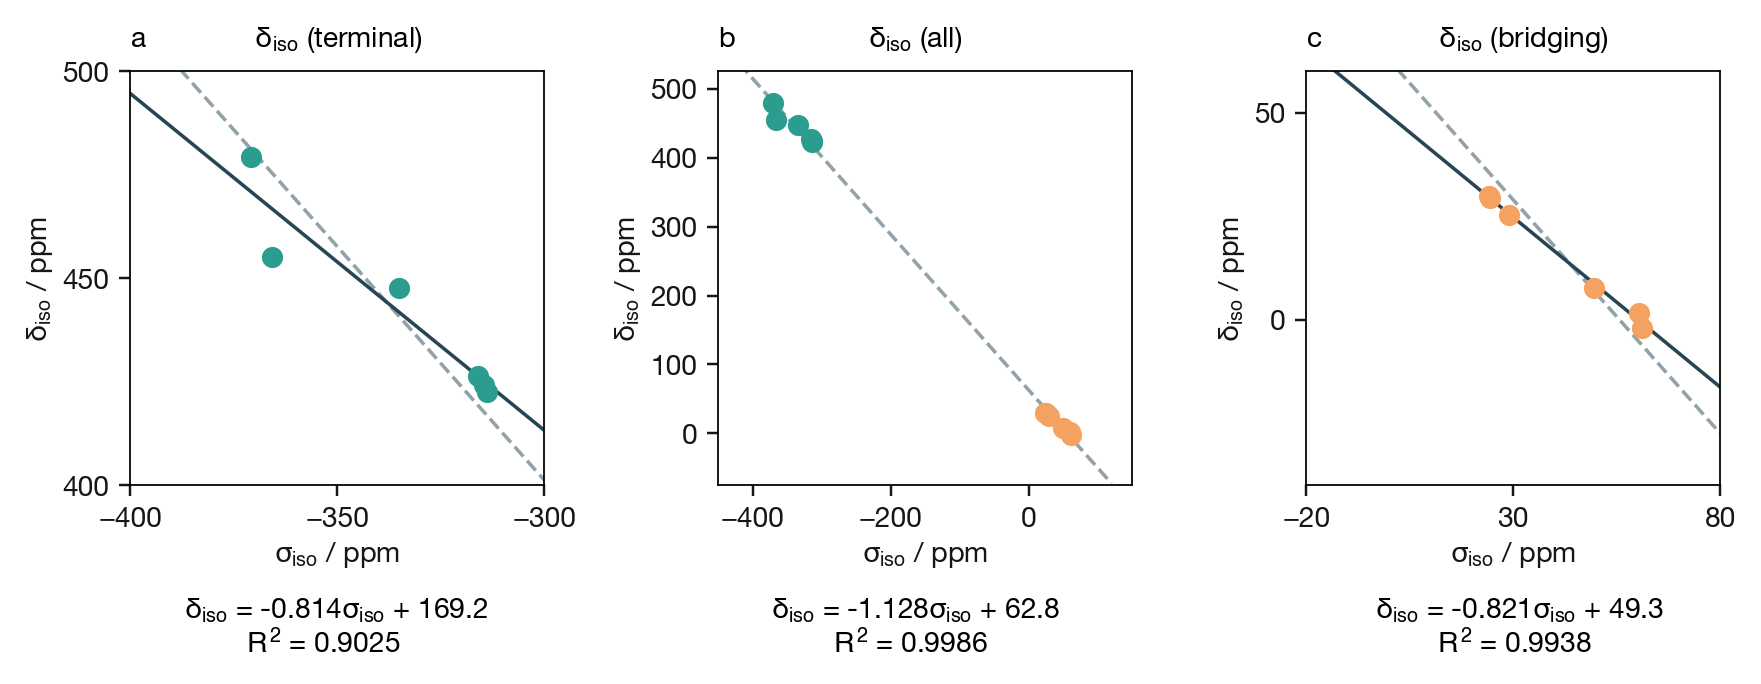

In [8]:
parse_iso_data(file_in='../Data/TiF4_NMR_data_Murakami.csv',
               file_out='../Figures/TiF4_NMR_fit_Murakami.pdf')

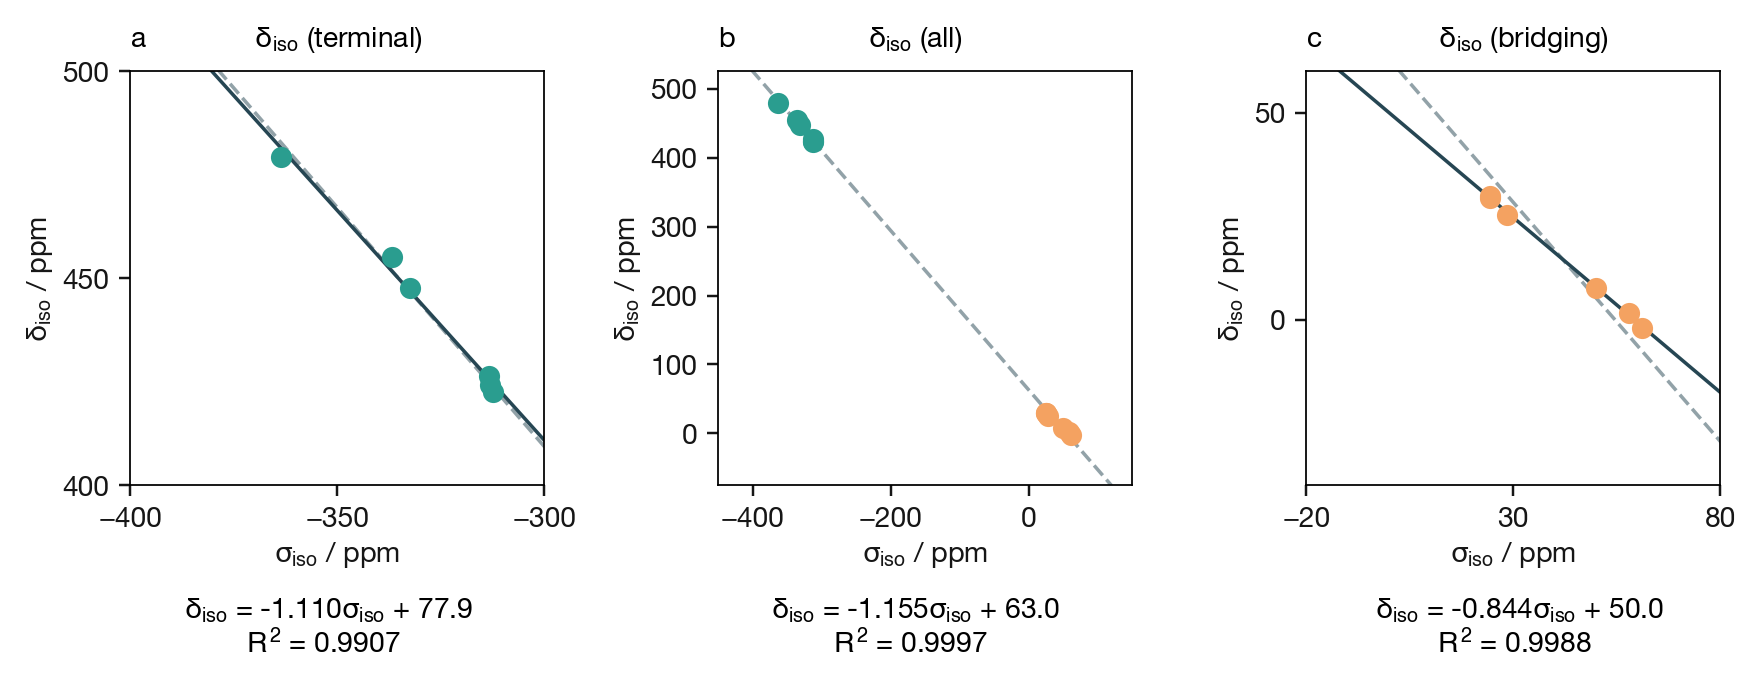

In [9]:
parse_iso_data(file_in='../Data/TiF4_NMR_data_CASTEP.csv',
               file_out='../Figures/TiF4_NMR_fit_CASTEP.pdf')

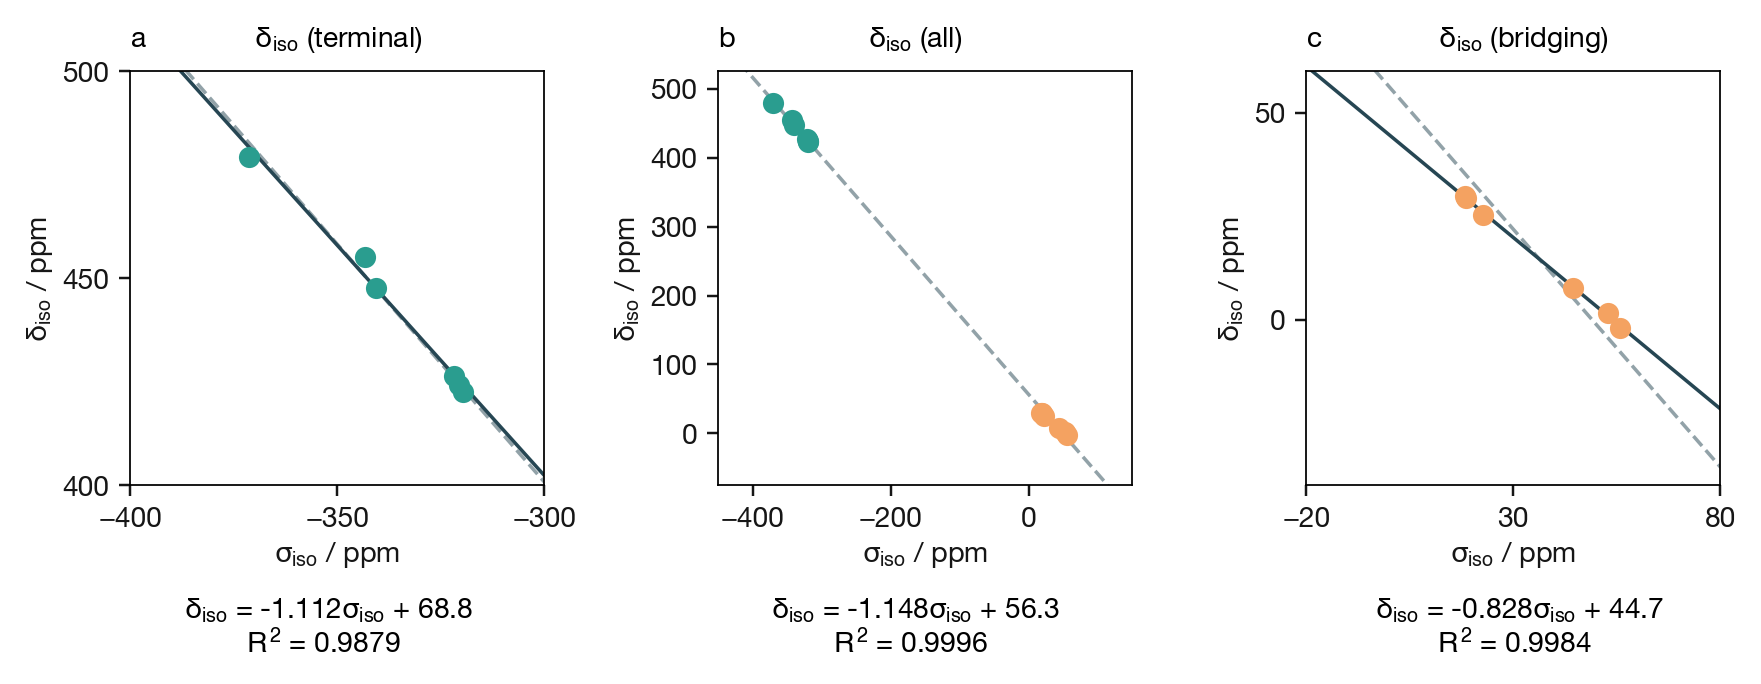

In [10]:
parse_iso_data(file_in='../Data/TiF4_NMR_data_VASP.csv',
               file_out='../Figures/TiF4_NMR_fit_VASP.pdf',
               read_csa=False)

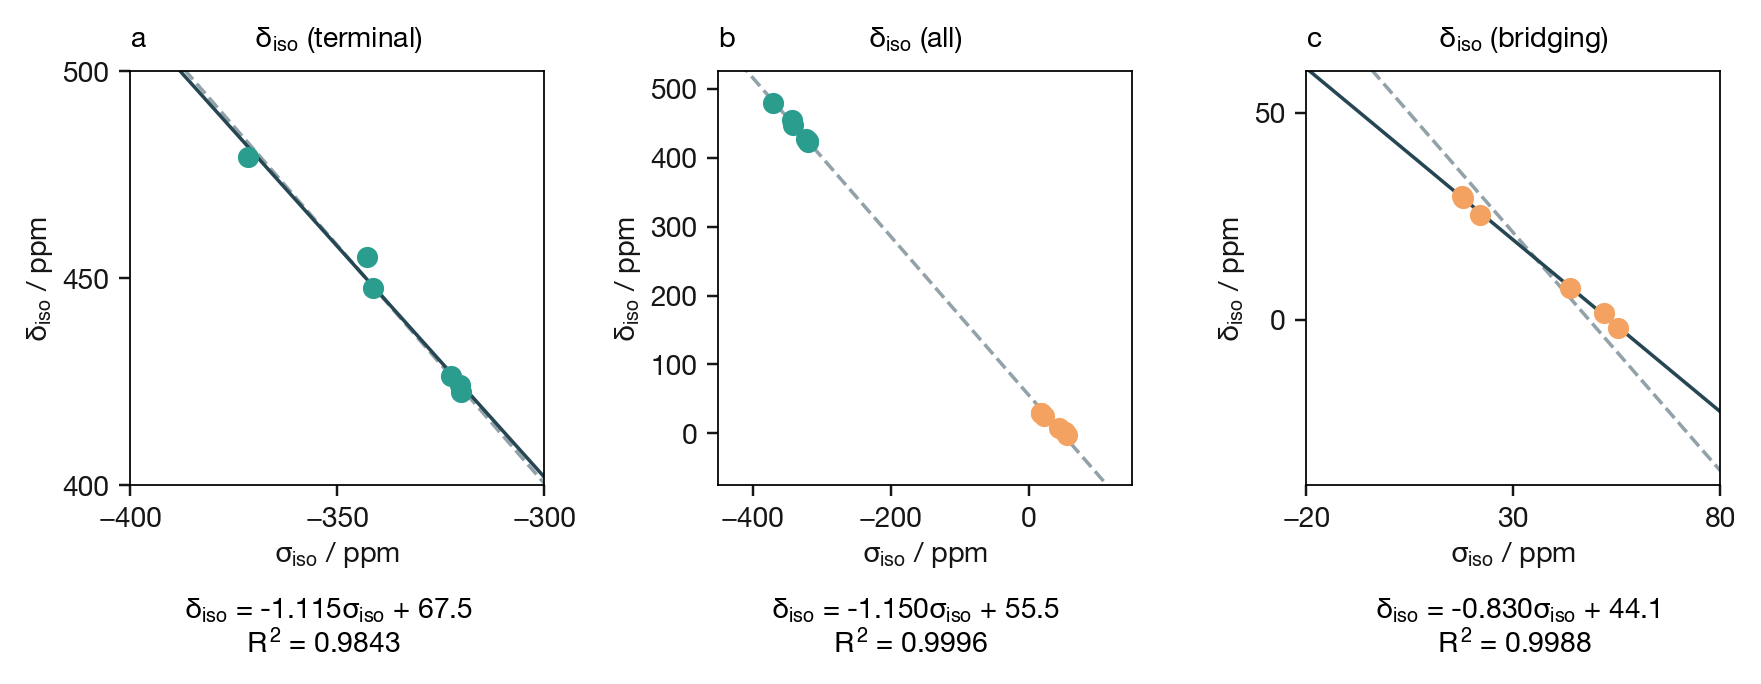

In [11]:
parse_iso_data(file_in='../Data/TiF4_NMR_data.csv',
               file_out='../Figures/TiF4_NMR_fit.pdf',
               read_csa=True)